# build obs_vista camera description

In this notebook we will build the files describing the VISTA camera geometry and properties. We are now using the gen 3 yaml format to describe the camera. 

https://github.com/lsst/obs_base/blob/master/python/lsst/obs/base/yamlCamera.py

For stacks the gain is effectively multiplied by the number of exposures (6). However there are complications due to clipping. We are currently working on replacing the per stack gain with a per exposure gain such that the gain must be multiplied by the exposure number when computing the variance later.

http://casu.ast.cam.ac.uk/surveys-projects/vista/technical/vista-gain

In [1]:
# What version of the Stack are we using?
! eups list -s | grep lsst_distrib
! eups list -s | grep obs_vista

lsst_distrib          22.0.1-3-g7ae64ea+ab4e4379a1 	w_latest w_2021_35 d_2021_08_25 setup
obs_vista             22.0.0-2   	current setup


## 1 Load camera data files
Originally we produced a fits file for each ccd based on the obs_subaru example. Now we are deprecating all gen 2 code and using the yaml camera description format only.

In [72]:
import yaml
import lsst
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import lsst.geom as geom
import numpy as np

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord, Angle, AltAz, EarthLocation
from astropy.wcs import WCS
import astropy.units as u

import matplotlib.pyplot as plt

In [3]:
#Use an example stack to reverse engineer the camera geometry
ex_stack='/Users/raphaelshirley/Documents/github/lsst-ir-fusion/dmu0/dmu0_VISTA/dmu0_VIDEO/data/20121122/v20121122_00088_st.fit'
ex_fit='/Users/raphaelshirley/Documents/github/lsst-ir-fusion/dmu0/dmu0_VISTA/dmu0_VIDEO/data/20121122/v20121122_00088.fit'
gain = Table.read('./gain.csv')
readout_noise = Table.read('./readout_noise.csv')
saturation = Table.read('./saturation.csv')

In [4]:
gain #electrons/ADU

id,NB118,Z,Y,J,Average
int64,float64,float64,float64,float64,float64
1,3.648,3.628,3.63,3.717,3.66
2,4.28,4.251,4.206,4.247,4.25
3,3.957,3.947,3.858,4.045,3.95
4,4.154,4.102,4.041,4.335,4.16
5,4.16,4.139,4.125,4.517,4.24
6,4.063,4.074,4.11,4.179,4.11
7,3.882,3.78,3.787,3.903,3.84
8,4.153,4.216,4.176,4.326,4.22
9,4.639,4.5,4.396,4.589,4.53


In [5]:
readout_noise # ADU?

id,NB118,Z,Y,J
int64,float64,float64,float64,float64
1,22.903,22.782,22.791,27.231
2,22.394,26.694,22.007,26.665
3,20.708,24.783,20.186,25.402
4,21.734,25.758,21.145,27.222
5,21.77,25.989,21.586,28.364
6,21.258,25.579,21.504,26.241
7,24.378,23.737,19.814,24.505
8,21.732,26.474,21.853,27.16
9,19.418,18.838,18.401,19.209


In [6]:
saturation #ADU? non-linearity - percent

detector,saturation,non-linearity
int64,int64,float64
1,33000,2.2
2,32000,3.3
3,33000,3.8
4,32000,3.5
5,24000,2.0
6,26000,3.0
7,35000,2.0
8,33000,3.4
9,35000,3.3


## Camera geomtry
It is possible to set a given CCD world coordinate system using the camera geometry and the telescope tracking radec. We may therefore want to describe the camera geometry by taking an example exposure and taking the offset of the pixels from the reference radec in the centre of the focal plane. These will be different for stacks vs single exposures due to dithers changing the pixel bounding boxes. These will also differ depending on the dither patterns adopted by a given survey.

1 (5406.375, 6832.391) (array(5405.375), array(6831.391)) <SkyCoord (ICRS): (ra, dec) in deg
    (35.89365276, -4.12471366)>
2 (2482.837, 6845.058) (array(2481.837), array(6844.058)) <SkyCoord (ICRS): (ra, dec) in deg
    (35.61864946, -4.12380322)>
3 (-431.6327, 6849.338) (array(-432.6327), array(6848.338)) <SkyCoord (ICRS): (ra, dec) in deg
    (35.3427475, -4.12413524)>
4 (-3348.992, 6852.811) (array(-3349.992), array(6851.811)) <SkyCoord (ICRS): (ra, dec) in deg
    (35.06691776, -4.12529353)>
5 (5396.107, 2949.336) (array(5395.107), array(2948.336)) <SkyCoord (ICRS): (ra, dec) in deg
    (35.89620332, -4.49025329)>
6 (2477.565, 2953.229) (array(2476.565), array(2952.229)) <SkyCoord (ICRS): (ra, dec) in deg
    (35.61995316, -4.49020325)>
7 (-439.3481, 2957.282) (array(-440.3481), array(2956.282)) <SkyCoord (ICRS): (ra, dec) in deg
    (35.34256296, -4.49054472)>
8 (-3354.422, 2964.089) (array(-3355.422), array(2963.089)) <SkyCoord (ICRS): (ra, dec) in deg
    (35.0657635, -4.49112

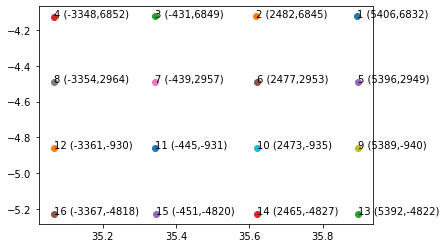

In [77]:
f=fits.open(ex_stack)
for i in range(1,17):
    w=WCS(f[i].header)
    print(i,
        (f[i].header['CRPIX1'],f[i].header['CRPIX2']),
        w.world_to_pixel(SkyCoord(f[i].header['CRVAL1']*u.deg,f[i].header['CRVAL2']*u.deg)),
        w.pixel_to_world(500,500)
    )
    
    plt.scatter(w.pixel_to_world(500,500).ra.deg,w.pixel_to_world(500,500).dec.deg)
    plt.annotate(
        "{} ({},{})".format(i,int(f[i].header['CRPIX1']),int(f[i].header['CRPIX2'])),
        (w.pixel_to_world(500,500).ra.deg,w.pixel_to_world(500,500).dec.deg))


In [8]:
f=fits.open(ex_fit)
for i in range(1,17):
    print(i)
    w=WCS(f[i].header)
    print(
        #(f[i].header['CRVAL1']*u.deg,f[i].header['CRVAL2']*u.deg),
        w.world_to_pixel(SkyCoord(f[i].header['CRVAL1']*u.deg,f[i].header['CRVAL2']*u.deg))
    )

(array(5389.2), array(6842.))


 [astropy.io.fits.verify]


(array(2470.8), array(6842.))
(array(-447.6), array(6842.))
(array(-3366.), array(6842.))
(array(5389.2), array(2950.8))
(array(2470.8), array(2950.8))
(array(-447.6), array(2950.8))
(array(-3366.), array(2950.8))
(array(5389.2), array(-940.4))
(array(2470.8), array(-940.4))
(array(-447.6), array(-940.4))
(array(-3366.), array(-940.4))
(array(5389.2), array(-4831.6))
(array(2470.8), array(-4831.6))
(array(-447.6), array(-4831.6))
(array(-3366.), array(-4831.6))


## Gen 3 YAML file version

In gen 3 the camera is defined in a single yaml file. Since we are currently developing obs_vista to be compatible with both we here also make the yaml file. gen 2 will be deprecated fully at some point before LSST commences.

In [9]:
#plateScale = 16.95    # Calculated from 0.339 arcesc/px and px = 0.02 mm
#1.24 from necam example
plateScale= 0.336 # arcsec 

In [10]:
camera = {
    'name': 'vista',
    'plateScale':plateScale,
    'transforms': {
        'nativeSys': 'FocalPlane',
        'FieldAngle': {
            'transformType': 'radial',
            'coeffs': [0.0, 1.0]
        }
    },
    'CCDs': {}
    
}
    
    


In [12]:
float(w.world_to_pixel(SkyCoord(f[i].header['CRVAL1']*u.deg,f[i].header['CRVAL2']*u.deg))[1])

-4831.6

In [90]:
ccdSize=2048 #2048 #This must be smaller than the actual image
spacer=200
f=fits.open(ex_stack)
for i in range(16):
    h=f[i+1].header
    w=WCS(h)
    ref_pos=w.world_to_pixel(SkyCoord(h['CRVAL1']*u.deg,h['CRVAL2']*u.deg))
    this_dict={
        'name': 'ccd{}'.format(i+1),
        'id': i+1,
        'serial': str(i+1),
        'detectorType': 0,
        'bbox': [[0,0], [ccdSize, ccdSize]], #values for a single exposure - how does this behave when given stacks with a larger value?
        'pixelSize': [0.02,0.02],#mm
        'transformDict':{
            'nativeSys': 'Pixels',
            'transforms': 'None'
        },
        'refpos': [h['CRPIX1'],h['CRPIX2']],#[2048,2048],#[h['CRPIX1'],h['CRPIX2']],#[float(ref_pos[0]),-float(ref_pos[1])+h['NAXIS2']],#[0,0], #hacking this to get radec corners correct
        'offset': [0,0],#[h['CRPIX1']*0.02,h['CRPIX2']*0.02],
        'transposeDetector': False,
        'pitch': 0.0,
        'yaw': 0.0,
        'roll': 0.0,
        'amplifiers':{
            'AMP_E2V':{
                'rawBBox': [[0,0],[ccdSize, ccdSize]],
                'hdu': i+1 ,
                'ixy': [0,0],
                'perAmpData': True,
                'rawDataBBox': [[0,0],[ccdSize, ccdSize]],
                'rawSerialOverscanBBox': [[spacer,spacer],[spacer, spacer]],
                'rawParallelOverscanBBox': [[spacer,spacer],[spacer, spacer]],
                'rawSerialPrescanBBox': [[spacer,spacer],[spacer, spacer]],
                'readCorner': 'LL',
                'gain': float(gain[i]['Average'] * 7),
                'readNoise': float(
                    np.mean([
                        readout_noise[i]['Z'],
                        readout_noise[i]['Y'],
                        readout_noise[i]['J']
                    ])
                ),
                'saturation': int(saturation[i]['saturation']),
                'flipXY': [False, False],
                'linearityCoeffs': [
                    float(saturation[i]['non-linearity']/100), 
                    int(saturation[i]['saturation'])
                ],
                'linearityType': "None",
                'linearityThreshold': 0,
                'linearityMax': int(saturation[i]['saturation']),
            }
        }
    }
    camera['CCDs']['ccd{}'.format(i+1)]=this_dict

In [91]:
camera

{'name': 'vista',
 'plateScale': 0.336,
 'transforms': {'nativeSys': 'FocalPlane',
  'FieldAngle': {'transformType': 'radial', 'coeffs': [0.0, 1.0]}},
 'CCDs': {'ccd1': {'name': 'ccd1',
   'id': 1,
   'serial': '1',
   'detectorType': 0,
   'bbox': [[0, 0], [2048, 2048]],
   'pixelSize': [0.02, 0.02],
   'transformDict': {'nativeSys': 'Pixels', 'transforms': 'None'},
   'refpos': [5406.375, 6832.391],
   'offset': [0, 0],
   'transposeDetector': False,
   'pitch': 0.0,
   'yaw': 0.0,
   'roll': 0.0,
   'amplifiers': {'AMP_E2V': {'rawBBox': [[0, 0], [2048, 2048]],
     'hdu': 1,
     'ixy': [0, 0],
     'perAmpData': True,
     'rawDataBBox': [[0, 0], [2048, 2048]],
     'rawSerialOverscanBBox': [[200, 200], [200, 200]],
     'rawParallelOverscanBBox': [[200, 200], [200, 200]],
     'rawSerialPrescanBBox': [[200, 200], [200, 200]],
     'readCorner': 'LL',
     'gain': 25.62,
     'readNoise': 24.268,
     'saturation': 33000,
     'flipXY': [False, False],
     'linearityCoeffs': [0.02

In [92]:


with open('vircam.yaml', 'w') as file:
    documents = yaml.dump(camera, file)